In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sat Jan 20 21:46:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [2]:
def get_kl(M, N, k, post_sigma, elem_sigma, prior_sigma=1.0):
    # z : (M, z)
    # mu : (N, z)
    
    z = torch.randn(M, k).cuda() * prior_sigma
    mu = torch.randn(N, k).cuda() * post_sigma
    
    # (M, N) = sum((M, 1, z) - (1, N, z), dim=2)
    distance = torch.norm(z.unsqueeze(1) - mu.unsqueeze(0), dim=2) ** 2
    
    loss = -torch.mean(torch.logsumexp(-1/(2*elem_sigma**2) * distance, dim=1))
    return loss.item()

In [11]:
from tqdm import tqdm

M = 1024
N = 1024
ks = [1, 2, 4, 8, 16, 32, 64, 128]
post_sigmas = np.arange(0.0, 2.0, 0.01)
elem_sigma = 1e-8

results = np.array([[get_kl(M, N, k, post_sigma, elem_sigma) for k in ks] for post_sigma in post_sigmas])
print(results.shape)

(200, 8)


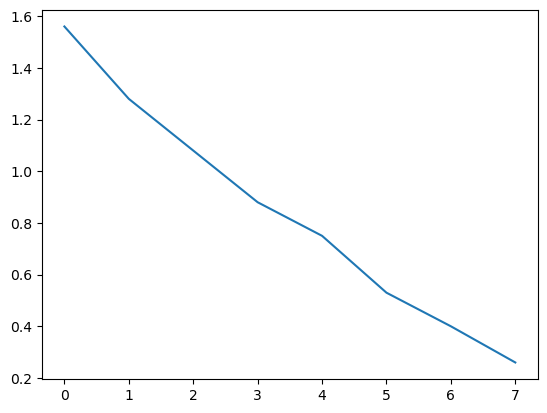

In [12]:
array = post_sigmas[np.argmin(results, axis=0)]
import matplotlib.pyplot as plt
plt.plot(array)
plt.show()